In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
train = pd.read_csv(r'C:\Users\SUNKANMI\Desktop\Kaggle\Titanic competition\train.csv')
#train.drop('Cabin', axis=1, inplace=True)
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [3]:
test = pd.read_csv(r'C:\Users\SUNKANMI\Desktop\Kaggle\Titanic competition\test.csv')
test.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


## Data Cleaning
We've loaded the data, now lets examine and clean the data

In [4]:
print(train.shape)
train.isnull().sum()

(891, 12)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We can see that the training data has 891 observations with 12 features. Age has 177 null values, Cabin has 687 null values and Embarked has 2. Now for the Test data.

In [5]:
print(test.shape)
test.isnull().sum()

(418, 11)


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We can see that the test data has 418 observations with 11 features. Age has 86 null values, Cabin has 327 null values and Fare has 1. In both datasets, the ratio of Null values in the Cabin column is too high compared to the non-null values. 
So we drop the Cabin column in both datasets, it is of negligible importance.

In [6]:
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

In [7]:
train['Title'] = train.Name.str.extract(' ([A-Za-z]+)\.')
test['Title'] = test.Name.str.extract(' ([A-Za-z]+)\.')
print(test.Title.value_counts()) 
print(train.Title.value_counts())

Mr        240
Miss       78
Mrs        72
Master     21
Rev         2
Col         2
Dr          1
Ms          1
Dona        1
Name: Title, dtype: int64
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Jonkheer      1
Don           1
Mme           1
Lady          1
Capt          1
Sir           1
Countess      1
Name: Title, dtype: int64


So we created a unique class called Title and from the above we can see that there are 4 major titles which are [Mr, Miss,Mrs,Master]. The rest will be later grouped into a class called Other, this should help prevent our model memorizing the data and overfitting. now we'll find which of these Titles has Age as null

In [8]:
null_age_train = train[train['Age'].isnull()]
null_age_test = test[test['Age'].isnull()]
print(null_age_test.Title.value_counts())
print(null_age_train.Title.value_counts())

Mr        57
Miss      14
Mrs       10
Master     4
Ms         1
Name: Title, dtype: int64
Mr        119
Miss       36
Mrs        17
Master      4
Dr          1
Name: Title, dtype: int64


We will now combine the Age and Title of both datasets and create a new dataframe and fill those null values

In [9]:
age_df = pd.concat([train[['Age', 'Title']], test[['Age', 'Title']]], axis=0)
nnaa = age_df[age_df['Age'].notnull()]
nnaa.shape

(1046, 2)

In [10]:
median_ages = nnaa[['Age', 'Title']].groupby(['Title'], as_index=False).median()
median_ages.set_index('Title', inplace=True)
print(median_ages.loc['Mr', 'Age'])
median_ages

29.0


,Age
Title,
Capt,70.0
Col,54.5
Countess,33.0
Don,40.0
Dona,39.0
Dr,49.0
Jonkheer,38.0
Lady,48.0
Major,48.5


Now to fill the missing values for the train and test datasets

In [11]:
for title in train.Title:
    if title == 'Mr':
        train['Age'].fillna(value=median_ages.loc['Mr', 'Age'], inplace=True)
    elif title == 'Miss':
        train['Age'].fillna(value=median_ages.loc['Miss', 'Age'], inplace=True)
    elif title == 'Mrs':
        train['Age'].fillna(value=median_ages.loc['Mrs', 'Age'], inplace=True)
    elif title == 'Master':
        train['Age'].fillna(value=median_ages.loc['Master', 'Age'], inplace=True)
    else:
        train['Age'].fillna(value=median_ages.loc['Dr', 'Age'], inplace=True)

In [12]:
for title in test.Title:
    if title == 'Mr':
        test['Age'].fillna(value=median_ages.loc['Mr', 'Age'], inplace=True)
    elif title == 'Miss':
        test['Age'].fillna(value=median_ages.loc['Miss', 'Age'], inplace=True)
    elif title == 'Mrs':
        test['Age'].fillna(value=median_ages.loc['Mrs', 'Age'], inplace=True)
    elif title == 'Master':
        test['Age'].fillna(value=median_ages.loc['Master', 'Age'], inplace=True)
    else:
        test['Age'].fillna(value=median_ages.loc['Miss', 'Age'], inplace=True)

Now to handle the rest of the null values in both datasets

In [13]:
train['Embarked'].fillna(value='S', inplace=True)
(test[['Pclass','Age', 'Fare', 'Embarked']]).sort_values(by='Age', ascending=False).head(18)
test[['Pclass', 'Fare']].groupby(['Pclass'], as_index=False).median()
test['Fare'].fillna(value=7.8958, inplace=True)
test.loc[152, :]

PassengerId                  1044
Pclass                          3
Name           Storey, Mr. Thomas
Sex                          male
Age                          60.5
SibSp                           0
Parch                           0
Ticket                       3701
Fare                       7.8958
Embarked                        S
Title                          Mr
Name: 152, dtype: object

In [14]:
print(train.isnull().sum())
print(test.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
Title          0
dtype: int64


As we can see, we have no more null values, our data is clean!

In [15]:
for title in train.Title:
    train['Title'] = train['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Mlle', 'Jonkheer', 'Countess', 'Lady', 'Mme',
                                            'Sir', 'Don', 'Capt'], 'Other')
    train['Title'] = train['Title'].replace('Ms', 'Miss')
    
for title in test.Title:
    test['Title'] = test['Title'].replace(['Dr', 'Rev', 'Col', 'Dona',], 'Other')
    test['Title'] = test['Title'].replace('Ms', 'Miss')

# Feature Importance
Now we will look at the features of our training set and see the relationship between them and Survival. This step very is important for feature selection in our Classifier

      Sex  Survived
0  female  0.742038
1    male  0.188908


C:\Users\SUNKANMI\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


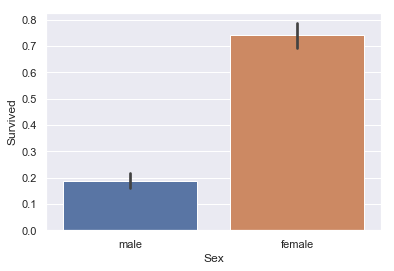

In [16]:
#Correlation between Sex and Survived
print(train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean())
sns.barplot(x='Sex', y='Survived', data=train)

It seems as though women have a much much higher survival rate than men do!

   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363


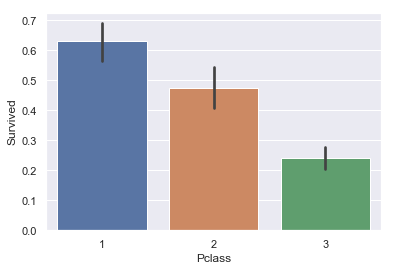

In [17]:
#Correlation between Pclass and Survived
print(train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean())
sns.barplot(x='Pclass', y='Survived', data=train)

As you could have guessed, the better the Pclass, the better the chances of survival!

  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009


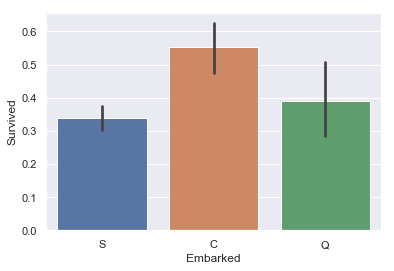

In [18]:
#Correlation between Embarked and Survived
print(train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean())
sns.barplot(x='Embarked', y='Survived', data=train)

   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000


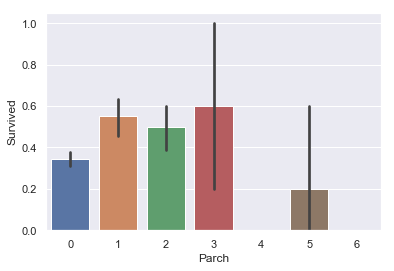

In [19]:
#Correlation between Parch and Survived
print(train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean())
sns.barplot(x='Parch', y='Survived', data=train)

   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000


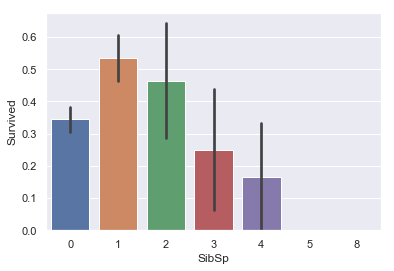

In [20]:
#Correlation between SibSp and Survived
print(train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean())
sns.barplot(x='SibSp', y='Survived', data=train)

From the data shown here, there is no evidence that suggests SibSp has an influence on Survival.

    Title  Survived
0  Master  0.575000
1    Miss  0.699454
2      Mr  0.156673
3     Mrs  0.792000
4   Other  0.423077


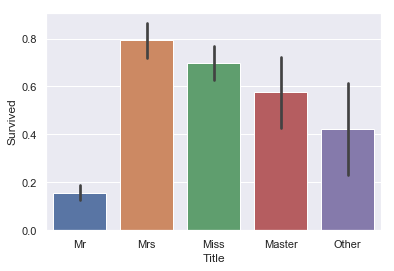

In [21]:
#Correlation between Title and Survived
print(train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())
sns.barplot(x='Title', y='Survived', data=train)

Bieng a Man on the Titanic was apparently a death sentence!

Sex     female  male
Pclass              
1           94   122
2           76   108
3          144   347


C:\Users\SUNKANMI\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


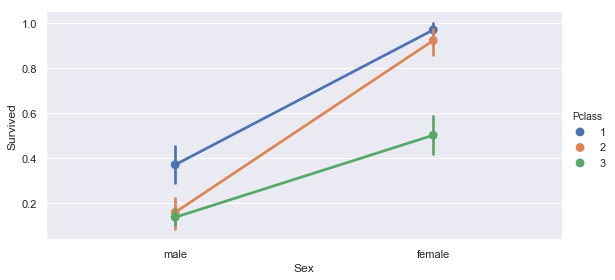

In [22]:
#Correlation between [Pclass & Sex] and Survived
p_sex = pd.crosstab(train['Pclass'], train['Sex'])
print(p_sex)
sns.factorplot('Sex', 'Survived', hue='Pclass', height=4, aspect=2, data=train)

From the this we can see, that a woman in 1st class has almost a 100% chance of Survival, women in 2nd class had a very good chance too. INFACT......Women in 3rd class had a better chance of survival than men in 1st class!!! WOW!!!!! JUST WOW!!!

# Feature Selection
Now we select the features with which to train our model with. From our Feature observation, we can see that the most correlating features to surviving the Titanic are: [Sex, Pclass, Title, Embarked, Parch]. Others such as [SibSp, Ticket, PAssengerId, Ticket] have too many distinct values and therefore dont influence the dataset as much.

The Age and Fare Columns will be scaled using the StandardScaler

In [23]:
#selecting the features to train model with
train = train.drop(['PassengerId', 'Name', 'SibSp', 'Ticket'], axis=1)
test = test.drop(['Name', 'SibSp', 'Ticket'], axis=1)

#now we map the object dtypes of Sex, Embarked and Title
train['Sex'] = train['Sex'].map({'female': 1, 'male': 0}).astype(int)
train['Embarked'] = train['Embarked'].map({'S':0, 'Q':1, 'C':2}).astype(int)
train['Title'] = train['Title'].map({'Mr':0, 'Mrs':1, 'Miss':2, 'Master':3, 'Other':4}).astype(int)

#test dataset
test['Sex'] = test['Sex'].map({'female': 1, 'male': 0}).astype(int)
test['Embarked'] = test['Embarked'].map({'S':0, 'Q':1, 'C':2}).astype(int)
test['Title'] = test['Title'].map({'Mr':0, 'Mrs':1, 'Miss':2, 'Master':3, 'Other':4}).astype(int)


In [24]:
a_age_fare = train[['Age', 'Fare']]
b_age_fare = test[['Age', 'Fare']]

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train = scaler.fit_transform(a_age_fare)
new_aaf = pd.DataFrame(scaled_train, index=a_age_fare.index, columns=a_age_fare.columns)

scaled_test = scaler.fit_transform(b_age_fare)
new_baf = pd.DataFrame(scaled_test, index=b_age_fare.index, columns=b_age_fare.columns)

In [26]:
train['Age'] = new_aaf['Age']
train['Fare'] = new_aaf['Fare']
train.head(2)

,Survived,Pclass,Sex,Age,Parch,Fare,Embarked,Title
0,0,3,0,-0.581659,0,-0.502445,0,0
1,1,1,1,0.649327,0,0.786845,2,1


In [27]:
test['Age'] = new_baf['Age']
test['Fare'] = new_baf['Fare']
test.head(2)

,PassengerId,Pclass,Sex,Age,Parch,Fare,Embarked,Title
0,892,3,0,0.355445,0,-0.497071,1,0
1,893,3,1,1.345161,0,-0.511934,0,1


# Model Selection and Training
Now for the fun stuff!

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

#### Train-Test Split

In [29]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_test = test.drop('PassengerId', axis=1).copy()

X_train.shape, X_test.shape, y_train.shape

((891, 7), (418, 7), (891,))

### Now lets train our models

#### Logistic Regression Model

In [30]:
#Logistic Regression
Log_model = LogisticRegression(solver='lbfgs')
Log_model.fit(X_train, y_train)
y_pred_Log = Log_model.predict(X_test)
Log_reg_accuracy = round(Log_model.score(X_train, y_train) * 100, 2)
print(str(Log_reg_accuracy) + '%')

80.13%


#### SVC Model

In [31]:
#SVC Model
svc_model = SVC(gamma='auto')
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
svc_accuracy = round(svc_model.score(X_train, y_train) * 100, 2)
print(str(svc_accuracy) + '%')

83.39%


#### Decision Tree Model

In [32]:
dtc = DecisionTreeClassifier()
gs_dtc = GridSearchCV(dtc,
                 {'max_depth': range(1, 10),
                 'min_samples_split': range(5, 51, 5)},
                 cv=5,
                 n_jobs=2)
gs_dtc.fit(X_train, y_train)
print(gs_dtc.best_params_)

{'max_depth': 9, 'min_samples_split': 45}


In [33]:
dtc_model = gs_dtc.best_estimator_
dtc_model.fit(X_train, y_train)
y_dtc = dtc_model.predict(X_test)
y_dtc_accuracy = round(dtc_model.score(X_train, y_train) * 100, 2)
print(str(y_dtc_accuracy) + '%')

85.86%


It appears the Decision Tree Model performed best. We'll use that as our solution



#### Kaggle Submission

In [46]:
submission = pd.DataFrame({'PassengerId': test['PassengerId'],
                          'Survived': y_dtc})

submission.to_csv('Final_submission.csv', index=False)
submission.head(4)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
